<h1>Charting the Field of Astronomy in Early Modern Europe Using Linked Open Data</h1>



<h2>[Summary / Tags]</h2>




In the early Nineties, Richard S. Westfall (1924–1996), a historian of science concerned with the cultural and social context of scientific activity, collected a considerable amount of information about a population of 630 scientists considered to have participated in the Scientific Revolution or in any case deserving of an entry in the Dictionary of Scientific Biography (Charles Gillispie, ed., 1979-1980). The extent of the population was thus defined by the representative character of these scholars from the encyclopedic point of view and brought together representatives from different scientific fields. The analysis of the rich information systematically collected by R. Westfall in different sources, and stored in a local database, allowed him to draw up a first profile of this population —with a primarily heuristic function— in an article published in 1996 [1]. The database was then made available to researchers on a website by Albert Van den Velden [2] and then incorporated into a website published by Robert A. Hatch where it is still available [3]. 

The multiplication of online resources over the last twenty years makes it possible to take Westfall's research agenda into a new dimension, in particular by enlarging the considered population and virtually integrating all the actors who have published works in this field. The starting point of this undertaking will be the bibliographic records of libraries and the correspondent authority files that provide basic information about the authors of the works held by these institutions. In addition, the vision of the LOD [4,5] has led to the linking of these resources through their identifiers or URIs which creates an information graph also involving platforms such as DBPedia, Wikidata, etc. Finally, more and more research projects in humanities and social sciences, particularly in the field of the history of knowledge, are making data available using semantic web technologies and connecting them to identifiers provided by authority files, following the logic of LOD [6, 7]. 

For the digital historian, the challenge therefore becomes to question these resources and to use this data for his/her own research agenda. In this paper, I will present a first stage of this approach using the ‘metadata’ about books and authors present in library authory file records, and show how the information they contain can be collected, wrangled and used to answer research questions. I will focus on a specific discipline, astronomy, and —in the same perspective as Richard Westfall, and considering the same historical period— use this information to ‘chart’ a scientific field, and more specifically the geographical origins of its actors, the places of publication of their books, and also, as far as possible, their places of activity and their evolution in time. I will also inspect the classifications provided by the librarians about books and their authors using a more or less controlled terminology, the co-occurrences of classification terms and their evolution over time with respect to the considered historical object, and, if possible, the networks of relationships emerging from this ‘metadata’. In contrast, the contents of the texts themselves will be left out of scope in this first approach.

The Thesaurus of CERL (Consortium of European Research Libraries) [8] will be at the heart of this endeavour. It aggregates authority files from several European Libraries, and notably the BNF and GND resources, for the period between 1450 and 1830 [9]. The aggregated data are published as LOD and provide a link to the original resources and external ones. These resources are being parsed and integrated using Python libraries. The methodology adopted will be presented in a series of Jupyter notebooks allowing to follow the process of data recovery, cleansing and integration. In order to combine data stemming from different repositories and data models, a common ontology suitable for intellectual history will be applied, and the data consequently wrangled and published —in the end of the process— in RDF format. Finally, a couple of dedicated Jupyter notebooks will propose a ‘chart’ of the field of astronomy in Early Modern Europe according to the mentioned line of inquiry (geographical mapping, classification, relationships and their and evolution in time) and thus support and accompany the storytelling of the paper that will present a possible model, i.e. a representation of the considered intellectual space from the point of view of the available information.

In [2]:
from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from importlib import reload
import pprint
import time
from shutil import copyfile
from operator import itemgetter
from collections import Counter

import requests
import re

import sqlite3 as sql
import csv
import json
import ast

In [148]:
from ipywidgets import (
    interact, fixed,
    interactive, Button,
    HTML, Layout,GridspecLayout,
    Output, jslink,
    IntSlider, ColorPicker,
    Text, SelectionRangeSlider,
    FloatRangeSlider, SelectMultiple, Checkbox,
    VBox, HBox)

In [149]:
from ipyleaflet import (Map,
                        basemap_to_tiles,
                        basemaps,
                        CircleMarker,
                        MarkerCluster,
                        LayerGroup, 
                        LayersControl,
                        WidgetControl,
                        Popup,
                        SplitMapControl
                       )
import pandas as pd
import sqlite3 as sql

#  Get the list of the relevant persons

In [7]:
### The maximum result number in one page is 100, 
#  this web scraping script parses the result and walks over all the pages

parser = etree.HTMLParser(recover=True)


### Documentation concerning pagination in Elasticsearch – and CERL
#   https://mindmajix.com/elasticsearch/pagination-and-retrieving-of-documents

###  Supported REST parameters:
#   https://www.elastic.co/guide/en/elasticsearch/reference/master/sql-rest-fields.html


from_pag = 0
interv = 100

id_list = []
id_count = []

while from_pag < 3500:  # Number defined according to the manual inspected query result, 3101 on 4 March 2021

    url = 'https://data.cerl.org/thesaurus/_search?query=(mathé*+OR+mathe*+OR+matem*+OR+astro*)+AND+type%3Acnp+AND+year_start:>1450+AND+year_end:<1771&size=100&from=' + str(from_pag)

    from_pag += interv 
    
    r = requests.get(url)

    et = etree.HTML(r.content, parser)

    id_count.append(len(et.xpath('//a/@href[contains(.,"rus/cnp")]')))
    
    [id_list.append(e.replace('/thesaurus/', '')) for e in et.xpath('//a/@href[contains(.,"rus/cnp")]') if e.replace('/thesaurus/', '') ] # not in id_list

In [8]:
len(id_list)

3091

Result number:
* Begin of March 2021: 3102
*  18 March 2021 : 2998
*  19 April 2021 : 3091

In [9]:
id_list[-5:]

['cnp02048444', 'cnp02199536', 'cnp02098294', 'cnp02044607', 'cnp01344247']

## Store result in CSV

Stored on 2nd April 2021

In [62]:
#  STOP : deactivated 
# with open('spreadsheets/query_cerl_persons_list.csv', 'w', newline='') as csvfile:
    r_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    i = 0
    r_writer.writerow(['index', 'value'])
    for l in id_list:
        r_writer.writerow([i, l])
        i += 1


# Get the data using the new JSON files

### Creating SQLite database

Documentation : https://docs.python.org/3/library/sqlite3.html

In [13]:
### Create database (if not existing) and connect

cn = sql.connect('db_stores/CERL.db')

In [14]:
c = cn.cursor()

""" Deactivated after table creation

# Drop table if exists
# c.execute('''DROP TABLE new_json_files;''')

# Create table 
c.execute('''CREATE TABLE new_json_files
             (pk_new_json_files INTEGER PRIMARY KEY, id_entity text, entity_std_name varchar (250), json text, timestmp text )''')

# Save (commit) the changes
cn.commit()


"""


cn.close()

###  Versioning of the SQLite database

This should be done before each relevant operation on the database

In [11]:
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now
# timestamp_formatted_for_file_name()
original_db = 'db_stores/CERL.db'
timestamped_db_copy = 'db_stores/CERL_' + timestamp_formatted_for_file_name() + '.db'
### Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)
copied_db = copyfile(original_db, timestamped_db_copy)
### Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)
copied_db = copyfile(original_db, timestamped_db_copy)
copied_db

'db_stores/CERL_20210419_223021.db'

In [12]:
db = sql.connect(original_db)

In [13]:
c = db.cursor()
# STOP #  c.execute('DELETE FROM new_json_files')
c.execute('SELECT COUNT(*) FROM new_json_files')
print(c.fetchone())
db.close()

(3091,)


## Get the JSON files from the CERL server and store them into the SQLite database

#### Preparing address list

In [15]:
lread = []
with open('spreadsheets/query_cerl_persons_list.csv', newline='') as csvfile:
    fread = csv.reader(csvfile, delimiter=',')
    lread = [l for l in fread]

In [17]:
cnp_list = [l[1] for l in lread[1:]]
print(len(cnp_list))
cnp_list[:3]

3091


['cnp01382157', 'cnp01371511', 'cnp01443734']

### Querying the CERL database

In [53]:
cn = sql.connect('db_stores/CERL.db')

In [44]:
##  Import JSON files into database

imported_json_files = []
for f in cnp_list:
    id_file = f
    try:
        r = requests.get('https://data.cerl.org/thesaurus/'+ id_file +'?format=json&pretty')
        time.sleep(0.1)
        json_doc = r.text.replace("'", "''")
        ## STOP ##          cn.execute("INSERT INTO new_json_files (id_entity, json, timestmp) VALUES ('"+ \
                  f + "','" + json_doc + "', datetime('now', 'localtime'))")
        ## STOP ##         cn.commit()
    except Exception as e:         
        imported_json_files.append([f,False,e])
    else:
        imported_json_files.append([f,True, ''])

In [45]:
print(imported_json_files[-5:])
len(imported_json_files)

[['cnp02048444', True, ''], ['cnp02199536', True, ''], ['cnp02098294', True, ''], ['cnp02044607', True, ''], ['cnp01344247', True, '']]


3091

In [47]:
### write imported file list
with open('db_stores/imported_json_files.csv', 'w', newline='') as csvfile:
    #  STOP  #     r_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)

    r_writer.writerow(['file', 'result', 'error'])
    for l in imported_json_files:
        r_writer.writerow(l)

In [55]:
cn.close()

In [ ]:
### there where no errors at import
errors = []
for e in imported_json_files:
    if e[1] == False:
        errors.append(e[0])
        ### Errors : 0
len(errors)

### Count the produced data

In [7]:
cn = sql.connect('db_stores/CERL.db')

In [8]:
### Imported : 3019
c = cn.cursor()
# STOP #  c.execute('DELETE FROM new_json_files')
c.execute('SELECT COUNT(*) FROM new_json_files')
print(c.fetchone()[0])

3091


In [9]:
cn.close()

# Explore the inserted data

### Explore the JSON documents' structure

In [56]:
cn = sql.connect('db_stores/CERL.db')

In [57]:
c = cn.cursor()
c.execute('SELECT * FROM new_json_files')
result_l = c.fetchall()

#### Inspect stored data (example)

In [27]:
print(len(result_l))
## inspect result ##   pprint.pprint(result_l[:2])

d = ast.literal_eval(result_l[1][3])
type(d)

3091


dict

In [22]:
print(d['_id'])
z = [print(e) for e in d['data']['extDataset'] if e['typeOfResource'] == 'orig']
[(e['start'], e['end']) for e in d['data']['bioDates'] ][0]

cnp01371511
{'code': 'PARB', 'note': [{'lang': 'eng', 'text': 'Authority record'}], 'typeOfResource': 'orig', 'searchTerm': 'http://catalogue.bnf.fr/ark:/12148/cb121711117'}
{'searchTerm': 'http://catalogue.bnf.fr/ark:/12148/cb13622661c', 'code': 'PARB', 'typeOfResource': 'orig', 'note': [{'text': 'Authority record', 'lang': 'eng'}]}


(1679, 1767)

In [23]:
### Keys ('fields') available in a specific document

(d['_id'],d['data'].keys())

('cnp01371511',
 dict_keys(['typeOfEntry', 'foundIn', 'geoNote', 'external', 'previousId', 'heading', 'name', 'imprintSource', 'bioDates', 'actNote', 'generalNote', 'gender', 'place', 'extDataset']))

###  Parse the JSON files


After storing the JSON web documents into the SQLite database you have to parse them into a dictionary Python document in order to be able to extract information.

During this process, 16 documents out of 3101 showed to have '502 Proxy Error'. See below.



In [28]:
documents = []
keys_list = []
cerl_cpn_list = []
errors = []
for i in result_l:
    try:
        ## used ast.literal_eval instead of json.loads
        d = ast.literal_eval(i[3])
        keys_list.append([i[1],list(d['data'].keys())])
        documents.append([])
    except Exception as e:
        errors.append([i[0], e])
        cerl_cpn_list.append([i[1], e])

In [29]:
### Errors list

print(len(errors))
l_errors = [e[0] for e in errors]
print(l_errors)
print(len(cerl_cpn_list))
lcpn_errors = [e[0] for e in cerl_cpn_list]
print(lcpn_errors)

0
[]
0
[]


In [30]:
len(keys_list)

3091

### Get missing data (because of proxy errors) and update the database


At first inspection, no data appeared to be missing but parsing the JSON data in the next step showed that around 0.5 % of the files had not been correctly retrieved.

The list of not retrieved files was stored in the _lcpn_errors_ variable.


The followin script retreives once again the missing files and updates the JSON fields with the new data. 



In [44]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()

In [34]:
### Exemple of found errors, before new retrieval: 
#  ['cnp01880566', 'cnp01342319', 'cnp00611867', 'cnp01341256']

errors = lcpn_errors
errors

[]

In [35]:
##  Import JSON files into database

imported_json_files = []
for f in errors:
    id_file = f
    try:
        r = requests.get('https://data.cerl.org/thesaurus/'+ id_file +'?format=json&pretty')
        time.sleep(0.2)
        json_doc = r.text.replace("'", "''")
        
        ## STOP ##          
        c.execute("UPDATE new_json_files SET json = '"+ json_doc  \
                  + "', timestmp = datetime('now', 'localtime') WHERE id_entity = '" \
                 + str(id_file) + "'")
    except Exception as e:         
        imported_json_files.append([f,False,e])
    else:
        imported_json_files.append([f,True, ''])

## STOP ##   cn.commit()     

# imported_json_files

In [37]:
cn.close()

# Split the 'fields' in the database

This step is needed in order to facilitate data inspection and information extraction.

A new table is created with the values of the fiels

## Get the keys' (fields') list and frequency

Fields description:  https://www.cerl.org/resources/cerl_thesaurus/editing/format


### Count fields per document

In [38]:
keys_list[:2]

[['cnp01382157',
  ['geoNote',
   'typeOfEntry',
   'foundIn',
   'external',
   'name',
   'heading',
   'previousId',
   'bioDates',
   'actNote',
   'generalNote',
   'extDataset',
   'gender']],
 ['cnp01371511',
  ['typeOfEntry',
   'foundIn',
   'geoNote',
   'external',
   'previousId',
   'heading',
   'name',
   'imprintSource',
   'bioDates',
   'actNote',
   'generalNote',
   'gender',
   'place',
   'extDataset']]]

In [39]:
count_list = []
for l in keys_list:
    count_list.append([l[0],Counter(l[1])])
    

In [40]:
z = [print(c) for c in count_list[10][1].items()]

('actNote', 1)
('place', 1)
('geoNote', 1)
('heading', 1)
('bioDates', 1)
('gender', 1)
('extDataset', 1)
('generalNote', 1)
('foundIn', 1)
('typeOfEntry', 1)
('related', 1)
('actDates', 1)
('imprintSource', 1)
('previousId', 1)
('external', 1)
('name', 1)
('extResource', 1)


In [41]:
print(len(count_list))
count_list[10][0], list(count_list[10][1].values()), list(count_list[10][1].keys())

3091


('cnp01005388',
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 ['actNote',
  'place',
  'geoNote',
  'heading',
  'bioDates',
  'gender',
  'extDataset',
  'generalNote',
  'foundIn',
  'typeOfEntry',
  'related',
  'actDates',
  'imprintSource',
  'previousId',
  'external',
  'name',
  'extResource'])

###  Test if any document has multiple instances of the same field

No document has twice or more the same field. Probably these are database fields in the original information system.

In [42]:
multiple_values_list = []
fields_per_document = []
reference_list = []
for l in count_list:
    freq_single = 0
    freq_multiple = 0
    multiple_list = []
    for i in l[1].items():
        if i[1] > 1:
            freq_multiple += 1
            multiple_list.append(i)
        else:
            freq_single += 1
    multiple_values_list.append([l[0],freq_single, freq_multiple, multiple_list])
len(multiple_values_list)

3091

In [43]:
a = [i[2] for i in multiple_values_list if i[2] > 0]
print(len(a))
multiple_values_list[10]

0


['cnp01005388', 17, 0, []]

In [44]:
[print(i[0]) for i in multiple_values_list if i[2] > 0 ]

[]

### Fields frequency per document

In [45]:
sl = sorted(Counter([i[1] for i in multiple_values_list]).items(), key = itemgetter(0))
print(sl)

[(5, 7), (6, 39), (7, 60), (8, 133), (9, 243), (10, 330), (11, 320), (12, 515), (13, 377), (14, 498), (15, 366), (16, 130), (17, 71), (18, 2)]


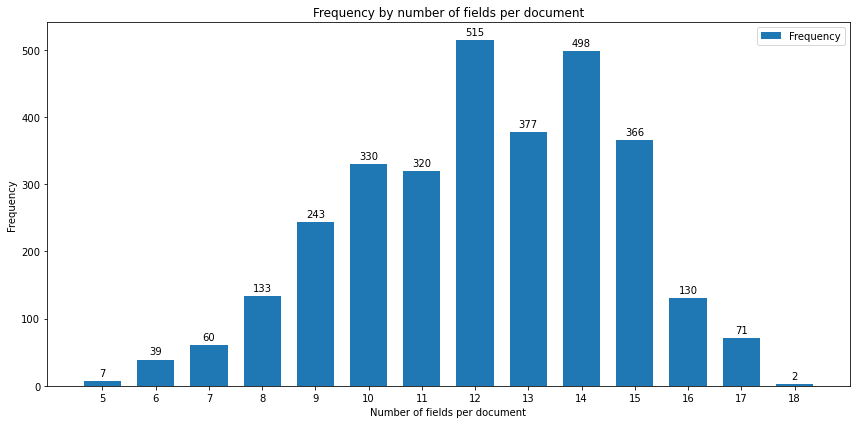

In [46]:
### https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

freq = [l[0] for l in sl]
height = [l[1] for l in sl]

x = np.arange(len(freq))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots( figsize=(12,6))

rects1 = ax.bar(x, height, width, label='Frequency')

try: 
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Number of fields per document')
    ax.set_title('Frequency by number of fields per document')
    ax.set_xticks(x)
    ax.set_xticklabels(freq)
except Exception as e:
    print(e)

ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()

plt.show()

### Field total frequency 

In [47]:
fields_list = []
for l in keys_list:
    fields_list += l[1]
c_list = Counter(fields_list)
d_list = sorted(dict(c_list).items(), key = itemgetter(1), reverse = True)
print(len(d_list))
d_list

19


[('typeOfEntry', 3091),
 ('heading', 3091),
 ('external', 3087),
 ('actNote', 2826),
 ('extDataset', 2751),
 ('foundIn', 2730),
 ('name', 2729),
 ('bioDates', 2705),
 ('generalNote', 2558),
 ('geoNote', 2302),
 ('imprintSource', 2061),
 ('place', 1846),
 ('gender', 1644),
 ('previousId', 1496),
 ('related', 1176),
 ('actDates', 848),
 ('extResource', 632),
 ('sign', 46),
 ('booksOwned', 7)]

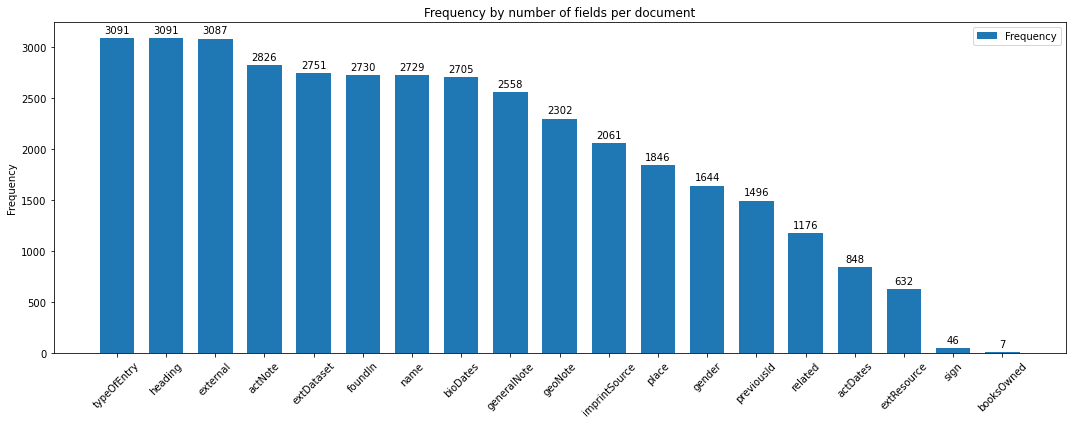

In [48]:
### https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

freq = [l[0] for l in d_list]
height = [l[1] for l in d_list]

width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(15,6))

rects1 = ax.bar(freq, height, width, label='Frequency')

try: 
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Frequency')
    ax.set_title('Frequency by number of fields per document')
    ax.set_xticks(freq)
    ax.set_xticklabels(freq, rotation = 45)
except Exception as e:
    print(e)

ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()

plt.show()

### Create new table in SQLite database with splitted fields

In [ ]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()

# Create table
# c.execute('''DROP TABLE person_properties;''')
c.execute('''CREATE TABLE person_properties
             (pk_person_properties INTEGER PRIMARY KEY, fk_new_json_files, id_person text, std_name text,
             typeOfEntry text, heading text, external text, actNote text, extDataset text, name text, foundIn text, 
             bioDates text, generalNote text, geoNote text, imprintSource text, place text, gender text, previousId text, 
             related text, actDates text, extResource text, sign text, booksOwned text, timestmp text,
             FOREIGN KEY(fk_new_json_files) REFERENCES new_json_files(pk_new_json_files))''')


# Save (commit) the changes 
# STOP # cn.commit()
cn.close()

### CERL fields description

* Fields description: https://www.cerl.org/resources/cerl_thesaurus/editing/format
* Codes: https://www.cerl.org/help/thesaurus/main
* Available search fields: https://www.cerl.org/resources/cerl_thesaurus/editing/indexing

#### Prepare inserts

In [ ]:
documents = []
inserts = []
errors = []
for i in result_l:
    try:
        pk = i[0]
        id = i[1]
        d = json.loads(i[3])

        try:
            typeOfEntry = str(d['data']['typeOfEntry'])
        except Exception as e:
            typeOfEntry = ''
        try:
            heading = str(d['data']['heading'])
        except Exception as e:
            heading = '' 
        try:
            external = str(d['data']['external'])
        except Exception as e:
            external = ''    
        try:
            actNote = str(d['data']['actNote'])
        except Exception as e:
            actNote = ''    
        try:
            extDataset = str(d['data']['extDataset'])
        except Exception as e:
            extDataset = ''    
        try:
            name = str(d['data']['name'])
        except Exception as e:
            name = ''    
        try:
            foundIn = str(d['data']['foundIn'])
        except Exception as e:
            foundIn = ''    
        try:
            bioDates = str(d['data']['bioDates'])
        except Exception as e:
            bioDates = ''    
        try:
            generalNote = str(d['data']['generalNote'])
        except Exception as e:
            generalNote = ''    
        try:
            geoNote = str(d['data']['geoNote'])
        except Exception as e:
            geoNote = ''    
        try:
            imprintSource = str(d['data']['imprintSource'])
        except Exception as e:
            imprintSource = ''    
        try:
            place = str(d['data']['place'])
        except Exception as e:
            place = ''    
        try:
            gender = str(d['data']['gender'])
        except Exception as e:
            gender = ''    
        try:
            previousId = str(d['data']['previousId'])
        except Exception as e:
            previousId = ''    
        try:
            related = str(d['data']['related'])
        except Exception as e:
            related = ''    
        try:
            actDates = str(d['data']['actDates'])
        except Exception as e:
            actDates = ''    
        try:
            extResource = str(d['data']['extResource'])
        except Exception as e:
            extResource = ''    
        try:
            sign = str(d['data']['sign'])
        except Exception as e:
            sign = ''    
        try:
            booksOwned = str(d['data']['booksOwned'])
        except Exception as e:
            booksOwned = ''    

        inserts.append([id, pk, typeOfEntry, heading, external, actNote, extDataset, name, foundIn, bioDates, generalNote, geoNote, imprintSource, place, gender, previousId, related, actDates, extResource, sign, booksOwned ])
        
    except Exception as e:
        errors.append([i[0], e])


## inspect ## inserts[5:7]        

In [61]:
c = cn.cursor()

try:

    # Empty table
    # c.execute('''DELETE FROM person_properties;''')
    # Fill table
    c.executemany('''INSERT INTO person_properties (id_person,fk_new_json_files,  
                 typeOfEntry, heading, external, actNote, extDataset, name, foundIn, 
                 bioDates, generalNote, geoNote, imprintSource, place, gender, previousId, 
                 related, actDates, extResource, sign, booksOwned, timestmp) 
                 VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?, datetime('now', 'localtime'))''', inserts)

except Exception as e:
    print(e)
    pass

# Save (commit) the changes 
# STOP # cn.commit()
cn.close()

# Explore data



 
* CERL: [Insitution and file codes in heading fields](https://cerl.org/resources/cerl_thesaurus/editing/format/list_of_insitution_and_file_codes_used_in_heading_fields)

## Produce standard name

In [62]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
query = """
SELECT pk_person_properties, heading 
FROM person_properties
"""
c.execute(query)
cl = c.fetchall()
cn.close()
len(cl)

3091

In [65]:
names_list = []
for i in cl:
    part = (ast.literal_eval(i[1]))[0]['part']
    try:
        entry = part[0]['entry']
    except Exception as e:
        entry = ''
    try:
        firstname = ', ' + part[1]['firstname']
    except Exception as e:
        firstname = ''
    names_list.append([entry + firstname, i[0]])

# Inspect result
names_list[3000]

['Wiener, Christoph', 3001]

In [66]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()

try:
    c.executemany("UPDATE person_properties SET std_name = ? WHERE pk_person_properties = ? ", names_list)
except Exception as e:
    print(e)
    pass

# Save (commit) the changes
# STOP #  cn.commit()


In [67]:
c = cn.cursor()
query = """
SELECT pk_person_properties, fk_new_json_files, std_name 
FROM person_properties
"""
c.execute(query)
cl = c.fetchall()
len(cl)

3091

In [68]:
names_list = [[i[2], i[1]] for i in cl]
names_list[5]

['Acquaviva, Andrea Matteo', 6]

In [69]:
c = cn.cursor()


try:
    c.executemany("UPDATE new_json_files SET entity_std_name = ? WHERE pk_new_json_files = ? ", names_list)
except Exception as e:
    print(e)
    pass

# Save (commit) the changes
# STOP #  
cn.commit()


In [70]:
cn.close()

## New table to store splitted properties

In [71]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()

# DROP table !
#  c.execute('''DROP TABLE entity_property;''')

try:
    c.execute('''CREATE TABLE entity_property
             (pk_entity_property INTEGER PRIMARY KEY, fk_new_json_files,
             property text, value text, 
             add_prop_1 text, add_val_1 text, 
             add_prop_2 text, add_val_2 text, 
             add_prop_3 text, add_val_3 text, 
             timestmp text,
             FOREIGN KEY(fk_new_json_files) REFERENCES new_json_files(pk_new_json_files))''')
except Exception as e:
    print(e)
    
# Save (commit) the changes
# STOP #  cn.commit()      

cn.close()

## Get dates

In [73]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
query = """
SELECT fk_new_json_files, bioDates, pk_person_properties
FROM person_properties
"""
c.execute(query)
cl = c.fetchall()
cn.close()
len(cl)

3091

In [75]:
properties = []
try: 
    jl = ast.literal_eval(cl[0][1])
    print(jl)
    for e in jl:
        print(e)
        print(e['start'])        
        print(e['end'])
        print(e['text'])
except Exception as e:
    print(e)

[{'lang': 'ger', 'start': '1499', 'end': '1588', 'text': '1499-1588. Todesjahr ca.'}, {'text': '1499-1588', 'end': '1588', 'lang': 'fre', 'start': '1499'}]
{'lang': 'ger', 'start': '1499', 'end': '1588', 'text': '1499-1588. Todesjahr ca.'}
1499
1588
1499-1588. Todesjahr ca.
{'text': '1499-1588', 'end': '1588', 'lang': 'fre', 'start': '1499'}
1499
1588
1499-1588


In [80]:
properties = []
errors = []
errors_field = []
for l in cl:
    try:
        jl = ast.literal_eval(l[1])
        for k in jl:
            try:
                properties.append([l[0], 'bioStart', str(k['start'])])
            except Exception as e:
                errors.append([l[0],e])
            try:
                properties.append([l[0], 'bioEnd', str(k['end'])])
            except Exception as e:
                errors.append([l[0],e])
            try:
                properties.append([l[0], 'bioText', str(k['text'])])
            except Exception as e:
                errors.append([l[0],e])
    except Exception as e:
         errors_field.append([l[0],e])
            
            
print(len(properties), len(errors), len(errors_field))
properties[1000]

12811 1037 386


[223, 'bioEnd', '1708']

In [81]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
try:    
    # Empty table # c.execute('''DELETE FROM person_properties;''')
    # Fill table
    c.executemany('''INSERT INTO entity_property (fk_new_json_files,  
                 property, value, timestmp) 
                 VALUES (?,?,?, datetime('now', 'localtime'))''', properties)

except Exception as e:
    print(e)

# Save (commit) the changes
# STOP #  cn.commit()
cn.close()

In [82]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
query = """
SELECT MIN(psp.value)
FROM entity_property psp
WHERE property = 'bioStart'
GROUP BY fk_new_json_files;
"""
c.execute(query)
cl = c.fetchall()
cn.close()
len(cl)

2632

### Plot dates

In [83]:
c_list = Counter([e[0] for e in cl])
d_list = [[int(e[0]), e[1]] for e in sorted(dict(c_list).items(), key = itemgetter(0), reverse = False) if e[0] >= '1400']
print(len(d_list))
print(d_list[:10])

286
[[1400, 7], [1401, 1], [1428, 1], [1429, 1], [1440, 2], [1445, 1], [1450, 2], [1451, 1], [1452, 3], [1453, 2]]


In [84]:
### Create a list of 20 years periods, i.e. the list of the first year, starting 1381
g_list = []
period = 20
d_start = 1381
i = 0
g_list = []
g_list.append(d_start)

while i < 21:
    d_start = d_start + period
    g_list.append(d_start)
    i += 1

In [85]:
print(g_list[:2])
min(g_list), max(g_list)

[1381, 1401]


(1381, 1801)

In [86]:
# Group by 20 years periods
i_list = []
for i in g_list:
    i_n = 0
    for l in d_list:
        if l[0] >= i and l[0] < (i + 20):
            i_n = i_n + l[1]
    i_list.append([i, i_n])        

In [87]:
print(i_list)

[[1381, 7], [1401, 1], [1421, 4], [1441, 33], [1461, 72], [1481, 174], [1501, 120], [1521, 183], [1541, 169], [1561, 229], [1581, 329], [1601, 217], [1621, 236], [1641, 241], [1661, 256], [1681, 216], [1701, 116], [1721, 21], [1741, 1], [1761, 0], [1781, 1], [1801, 0]]


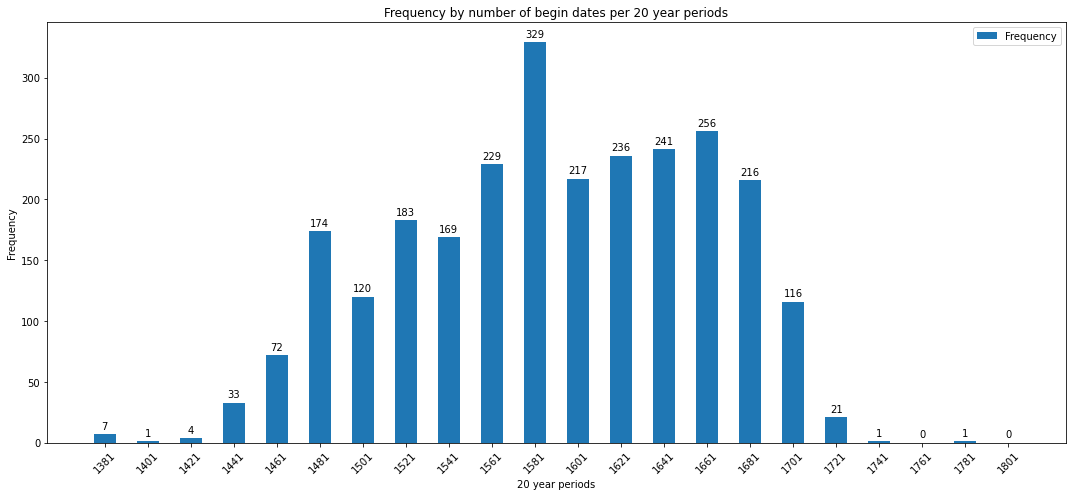

In [88]:
### https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

freq = [l[0] for l in i_list]
height = [l[1] for l in i_list]

width = 15/len(i_list)*15  # the width of the bars

fig, ax = plt.subplots(figsize=(15,7))

rects1 = ax.bar(freq, height, width, label='Frequency')

try: 
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('20 year periods')
    ax.set_ylabel('Frequency')
    ax.set_title('Frequency by number of begin dates per 20 year periods')
    ax.set_xticks(freq)
    ax.set_xticklabels(freq, rotation = 45)
except Exception as e:
    print(e)

ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()

plt.show()

## Get sameAs URIs

In [89]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
query = """
SELECT fk_new_json_files, extDataset, pk_person_properties
FROM person_properties
"""
c.execute(query)
cl = c.fetchall()
cn.close()
len(cl)

3091

In [90]:
properties = []
try: 
    jl = ast.literal_eval(cl[0][1])
    print(jl)
except Exception as e:
    print(e)

[{'typeOfResource': 'same', 'note': [{'lang': 'eng', 'text': 'Authority record'}], 'code': 'BNFR', 'searchTerm': 'http://data.bnf.fr/ark:/12148/cb14624324z'}, {'searchTerm': 'http://d-nb.info/gnd/119250616', 'code': 'DNBI', 'note': [{'lang': 'eng', 'text': 'Authority record'}], 'typeOfResource': 'same'}, {'code': 'VIAF', 'note': [{'lang': 'eng', 'text': 'Clustered authority record'}], 'typeOfResource': 'same', 'searchTerm': 'http://viaf.org/viaf/19935039'}, {'searchTerm': 'http://www.wikidata.org/entity/Q3502536', 'note': [{'lang': 'eng', 'text': 'Wikidata description set'}], 'typeOfResource': 'same', 'code': 'WDAT'}, {'searchTerm': 'http://catalogue.bnf.fr/ark:/12148/cb14624324z', 'code': 'PARB', 'note': [{'text': 'Authority record', 'lang': 'eng'}], 'typeOfResource': 'orig'}]


In [92]:
properties = []
errors = []
errors_field = []
for l in cl:
    try:
        jl = ast.literal_eval(l[1])
        for k in jl:
            try:
                searchTerm = str(k['searchTerm'])
            except Exception as e:
                errors.append([l[0],e])
            try:
                typeOfResource = str(k['typeOfResource'])
            except Exception as e:
                errors.append([l[0],e])
            try:
                code = str(k['code'])
            except Exception as e:
                errors.append([l[0],e])
                
            properties.append([l[0], 'sameAs', searchTerm, 'typeOfResource', typeOfResource, 'code', code])
            
    except Exception as e:
         errors_field.append([l[0],e])
            
print(len(properties), len(errors), len(errors_field))
properties[1000:1003]

12811 0 340


[[221,
  'sameAs',
  'http://en.wikipedia.org/wiki/Nicolaus_II_Bernoulli',
  'typeOfResource',
  'info',
  'code',
  'WIKI'],
 [221,
  'sameAs',
  'http://www.wikidata.org/entity/Q124001',
  'typeOfResource',
  'same',
  'code',
  'WDAT'],
 [221, 'sameAs', '117589144', 'typeOfResource', 'bibl', 'code', 'KAPE']]

In [93]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()

try:    
    # Empty table # c.execute('''DELETE FROM person_properties;''')
    # Fill table
    c.executemany('''INSERT INTO entity_property (fk_new_json_files,  
                 property, value, 
                 add_prop_1, add_val_1, 
                 add_prop_2, add_val_2, 
                 timestmp) 
                 VALUES (?,?,?,?,?,?,?, datetime('now', 'localtime'))''', properties)

except Exception as e:
    print(e)

# Save (commit) the changes
# STOP #  cn.commit()

cn.close()

### Explore references to external sources

These SQL queries can be executed directly on the database using a SQLite client, e.g. DBeaver

<code>
-- Group by type
SELECT count(*) AS eff, add_val_1 
FROM entity_property psp
WHERE property = 'sameAs'
GROUP BY add_val_1
ORDER BY eff DESC  ;

-- Group by origin
SELECT count(*) AS eff, add_val_2 
FROM entity_property psp
WHERE property = 'sameAs'
GROUP BY add_val_2
ORDER BY eff DESC  ;

-- Group by both type and origin
SELECT count(*) AS eff, add_val_1, add_val_2 
FROM entity_property psp
WHERE property = 'sameAs'
GROUP BY add_val_1, add_val_2
ORDER BY add_val_1, add_val_2;
    
-- double matching    
WITH tw1 AS (
SELECT fk_new_json_files, value 
FROM entity_property psp
WHERE property = 'sameAs'
AND add_val_1 IN ('orig', 'same')
ORDER BY fk_new_json_files
),
tw2 AS (
SELECT DISTINCT t1.fk_new_json_files id1, t2.fk_new_json_files id2
FROM tw1 t1, tw1 t2
WHERE t1.value = t2.value
AND t1.fk_new_json_files &lt; t2.fk_new_json_files
)
SELECT id2, COUNT(\*), GROUP_CONCAT(id1)
FROM tw2
GROUP BY id2
HAVING COUNT(\*) &gt; 1 ;
</code>    



In [95]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
query = """
SELECT *
FROM entity_property psp
WHERE property = 'sameAs'
AND add_val_1 IN ('orig', 'same')
"""
c.execute(query)
cl = c.fetchall()
cn.close()
print(len(cl))
cl[3]

10409


(12815,
 1,
 'sameAs',
 'http://www.wikidata.org/entity/Q3502536',
 'typeOfResource',
 'same',
 'code',
 'WDAT',
 None,
 None,
 '2021-04-19 23:30:37')

## Get places

In [96]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
query = """
SELECT fk_new_json_files, place, pk_person_properties
FROM person_properties
"""
c.execute(query)
cl = c.fetchall()
cn.close()
len(cl)

3091

In [97]:
properties = []
try: 
    jl = ast.literal_eval(cl[1][1])
    print(jl)
except Exception as e:
    print(e)

[{'start': '1767', 'note': [{'text': 'Lieu de mort', 'lang': 'fre'}], 'id': 'cnl00009361', 'part': [{'name': 'Genève, Suisse'}], 'typeOfPlace': 'deat'}, {'typeOfPlace': 'brth', 'id': 'cnl00014913', 'part': [{'name': 'Uzès'}], 'note': [{'text': 'Lieu de naissance', 'lang': 'fre'}], 'start': '1679'}, {'note': [{'lang': 'ger', 'text': 'Geburtsort'}], 'typeOfPlace': 'brth', 'part': [{'name': 'Uzès'}], 'id': 'cnl00014913'}, {'typeOfPlace': 'deat', 'id': 'cnl00006399', 'part': [{'name': 'Genf'}], 'note': [{'text': 'Sterbeort', 'lang': 'ger'}]}, {'note': [{'lang': 'ger', 'text': 'Geburtsort'}], 'tmp': '(GND)4517680-2', 'id': 'cnl00014913', 'part': [{'name': 'Uzès'}], 'typeOfPlace': 'brth'}, {'note': [{'text': 'Sterbeort', 'lang': 'ger'}], 'id': 'cnl00006119', 'tmp': '(GND)4020137-5', 'part': [{'name': 'Genf'}], 'typeOfPlace': 'deat'}]


In [101]:
properties = []
errors = []
errors_field = []
for l in cl:
    try:
        jl = ast.literal_eval(l[1])
        for k in jl:
            try:
                typeOfPlace = str(k['typeOfPlace'])
            except Exception as e:
                typeOfPlace = ''
                errors.append([l[0],e])
            try:
                id = str(k['id'])
            except Exception as e:
                id = ''
                errors.append([l[0],e])
            try:
                name = str(k['part'][0]['name'])
            except Exception as e:
                name = ''
                errors.append([l[0],e])
                
            properties.append([l[0], 'idPlace', id, 'typeOfPlace', typeOfPlace, 'name', name])
            
    except Exception as e:
         errors_field.append([l[0],e])
            
print(len(properties), len(errors), len(errors_field))
properties[61:65]

5264 465 1245


[[22, 'idPlace', 'cnl00006364', 'typeOfPlace', 'brth', 'name', 'Brüssel'],
 [22, 'idPlace', 'cnl00029116', 'typeOfPlace', 'deat', 'name', 'Antwerpen'],
 [23, 'idPlace', 'cnl00016096', 'typeOfPlace', 'actv', 'name', 'Ingolstadt'],
 [23,
  'idPlace',
  '',
  'typeOfPlace',
  'brth',
  'name',
  'Tramin an der Weinstraße']]

In [102]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
try:    
    # Fill table
    c.executemany('''INSERT INTO entity_property (fk_new_json_files,  
                 property, value, 
                 add_prop_1, add_val_1, 
                 add_prop_2, add_val_2, 
                 timestmp) 
                 VALUES (?,?,?,?,?,?,?, datetime('now', 'localtime'))''', properties)

except Exception as e:
    print(e)

# Save (commit) the changes
# STOP # cn.commit()

cn.close()

### Inspect the geographical place data

It appears that in the data :
* the same places have different cnl codes
* some places without code have a code (alphabetical order shows this)
* in the JSON files are aware of this internal links but they cannot be directly retrieved, the places IDs where not changed in the persons' files after matching
* it is therefore unavoidable to have redundancy in the retrieved data
* there are also some IDs that are not _cnl_ and therefore must be excluded

<code>
    
SELECT add_val_1,
       count( * ) eff
  FROM entity_property psp
 WHERE add_prop_1 = 'typeOfPlace'
 GROUP BY add_val_1
 ORDER BY eff DESC;
    
SELECT value ,
       count( * ) eff
  FROM entity_property psp
 WHERE add_prop_1 = 'typeOfPlace'
 GROUP BY value
 ORDER BY eff DESC;
    
    WITH tw1 AS (SELECT DISTINCT value, add_val_2
  FROM entity_property psp
 WHERE add_prop_1 = 'typeOfPlace')
SELECT *
FROM tw1
WHERE value LIKE 'cnl%'
ORDER BY add_val_2;
    
</code>    

## Get the JSON files about geogr. places from the CERL server and store them into the SQLite database

#### Preparing address list

In [108]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
query = """
SELECT DISTINCT value
  FROM entity_property psp
 WHERE add_prop_1 = 'typeOfPlace'
 AND value LIKE 'cnl%'
"""
c.execute(query)
cl = c.fetchall()
cn.close()
print(len(cl))
cl[1:3]

1185


[('cnl00014913',), ('cnl00006399',)]

In [109]:
id_list = [i[0] for i in cl]
print(len(id_list))
id_list[1]

1185


'cnl00014913'

### Get the data from the CERL API

In [110]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()

In [111]:
##  Import JSON files into database

imported_json_files = []
for f in id_list:
    id_file = f
    try:
        r = requests.get('https://data.cerl.org/thesaurus/'+ id_file +'?format=json&pretty')
        time.sleep(0.2)
        json_doc = r.text.replace("'", "''")
  
        ## STOP ##        
        c.execute("INSERT INTO new_json_files (id_entity, json, timestmp) VALUES ('"+ \
                  f + "','" + json_doc + "', datetime('now', 'localtime'))")
  
        ## STOP ##        cn.commit()
    
    except Exception as e:         
        imported_json_files.append([f,False,e])
    else:
        imported_json_files.append([f,True, ''])

In [112]:
c = cn.cursor()
c.execute("SELECT COUNT(*) FROM new_json_files WHERE id_entity LIKE 'cnl%'")
print(c.fetchone())
cn.close()

(1185,)


In [113]:
print(imported_json_files[-5:])
len(imported_json_files)

[['cnl00014920', True, ''], ['cnl00011260', True, ''], ['cnl00027229', True, ''], ['cnl00003090', True, ''], ['cnl00022308', True, '']]


1185

In [114]:
with open('db_stores/imported_json_files_places.csv', 'w', newline='') as csvfile:
    #  STOP  #     r_writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)

    r_writer.writerow(['file', 'result', 'error'])
    for l in imported_json_files:
        r_writer.writerow(l)

In [115]:
### there where no errors at import
errors = []
for e in imported_json_files:
    if e[1] == False:
        errors.append(e[0])
len(errors)        

0

## Explore the inserted data: get the places and geographical coordinates

### Add location data

In [117]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
c.execute("SELECT pk_new_json_files, id_entity, json FROM new_json_files WHERE id_entity LIKE 'cnl%';")
result_l = c.fetchall()
cn.close()

In [118]:
properties = []
errors = []
errors_field = []
for l in result_l:
    try:
        k = ast.literal_eval(l[2])
        try:
            place_st_name = str(k['data']['heading'][0]['part'][0]['entry'])            
        except Exception as e:
            place_st_name = ''
            errors.append([l[0],e])
        try:
            id = str(k['_id'])
        except Exception as e:
            id = ''
            errors.append([l[0],e])
        try:
            long = str(k['data']['location']['point']['long'])
        except Exception as e:
            long = ''
            errors.append([l[0],e])
        try:
            lat = str(k['data']['location']['point']['lat'])
        except Exception as e:
            lat = ''
            errors.append([l[0],e])

        properties.append([l[0], 'place_st_name', place_st_name, 'cerl_id', id, 'long', long, 'lat', lat])
            
    except Exception as e:
         errors_field.append([l[1],e])
            
print(len(properties), len(errors), len(errors_field))

1181 594 4


In [119]:
print(errors_field[:3])
errors_id = [i[0] for i in errors_field]

### BEWARE : in not empty reload JSON with query
errors_id

[['cnl00017057', SyntaxError('invalid syntax', ('<unknown>', 1, 1, '<!DOCTYPE html>\n'))], ['cnl00023264', SyntaxError('invalid syntax', ('<unknown>', 1, 1, '<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n'))], ['cnl00017393', SyntaxError('invalid syntax', ('<unknown>', 1, 1, '<!DOCTYPE html>\n'))]]


['cnl00017057', 'cnl00023264', 'cnl00017393', 'cnl00029932']

#### Issue : not existing CERL documents

These documents are not available any more : 'cnl00017057', 'cnl00017393' – although still referred to in the data

In [ ]:
### Locations are missing...

errors[:10]

## Produce new entity properties with geog. location

In [120]:
print(len(properties))
properties[61]

1181


[3153,
 'place_st_name',
 'Rouen',
 'cerl_id',
 'cnl00012658',
 'long',
 '1.08',
 'lat',
 '49.4291666666667']

In [121]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()

try:    
    c.executemany('''INSERT INTO entity_property (fk_new_json_files,  
                 property, value, 
                 add_prop_1, add_val_1, 
                 add_prop_2, add_val_2, 
                 add_prop_3, add_val_3, 
                 timestmp) 
                 VALUES (?,?,?,?,?,?,?,?,?, datetime('now', 'localtime'))''', properties)

except Exception as e:
    print(e)

# Save (commit) the changes
# STOP #  cn.commit()

cn.close()

## Get identical places using long/lat coordinates


<code>
    WITH tw1 AS (
    SELECT group_concat(add_val_1) cerl_ids,
           CAST (add_val_2 AS FLOAT) long,
           CAST (add_val_3 AS FLOAT) lat,
           count( * ),
           group_concat(value) noms
      FROM entity_property
     WHERE add_val_2 > '' AND 
           add_prop_2 = 'long'
     GROUP BY add_val_2,
              add_val_3
     ORDER BY noms
)
--SELECT * FROM tw1 ;    
SELECT t1.noms,
       t1.long,
       t1.lat,
       t2.noms,
       t2.long,
       t2.lat
  FROM tw1 t1,
       tw1 t2
 WHERE t1.cerl_ids > t2.cerl_ids AND 
       t1.lat BETWEEN t2.lat - 0.02 AND t2.lat + 0.02 AND 
       t1.long BETWEEN t2.long - 0.02 AND t2.long + 0.02;
</code>    

### Create internal references

In [122]:
result_l[0][0], result_l[0][1], ast.literal_eval(result_l[0][2])['data']['previousId']

(3092,
 'cnl00009361',
 ['cnl00006399',
  'cnl00002761',
  'cnl00004671',
  'cnl00004941',
  'cnl00009361',
  'cnl00022763',
  'cnl00028217',
  'cnl00028826',
  'cnl00032337'])

## Add the references to previous Id numbers of places

In [123]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
c.execute("SELECT pk_new_json_files, id_entity, json FROM new_json_files WHERE id_entity LIKE 'cnl%';")
result_l = c.fetchall()
cn.close()

### Inspect stored data

In [124]:
print(len(result_l))
## inspect result ##   pprint.pprint(result_l[:2])
d = json.loads(result_l[1][2])
type(d)

1185


dict

In [125]:
 ast.literal_eval(result_l[2][2])['data']['previousId']

['cnl00006399',
 'cnl00002761',
 'cnl00004671',
 'cnl00004941',
 'cnl00009361',
 'cnl00022763',
 'cnl00028217',
 'cnl00028826',
 'cnl00032337']

In [126]:
ld = [[z[1],  ast.literal_eval(z[2])['data']['previousId']] for z in result_l[:2]]
pprint.pprint(ld)

[['cnl00009361',
  ['cnl00006399',
   'cnl00002761',
   'cnl00004671',
   'cnl00004941',
   'cnl00009361',
   'cnl00022763',
   'cnl00028217',
   'cnl00028826',
   'cnl00032337']],
 ['cnl00014913', ['cnl00005435']]]


### Add references to previous Id numbers data

In [128]:
properties = []
errors = []
errors_field = []
for l in result_l:
    try:
        k = ast.literal_eval(l[2])
        kpid_list = []

        try:
            for kpid in k['data']['previousId']:                
                kpid_list.append([l[0], 'cerl_id', l[1], 'previous_cerl_id', kpid])
        except Exception as e:
            errors.append([l[0],e])

        properties += kpid_list
        # properties.append([l[0], 'place_st_name', place_st_name, 'cerl_id', id, 'long', long, 'lat', lat])
            
    except Exception as e:
         errors_field.append([l[1],e])
            
print(len(properties), len(errors), len(errors_field))            

3581 423 4


In [129]:
print(errors_field[:3])
errors_id = [i[0] for i in errors_field]

### BEWARE : in not empty reload JSON with query
errors_id

[['cnl00017057', SyntaxError('invalid syntax', ('<unknown>', 1, 1, '<!DOCTYPE html>\n'))], ['cnl00023264', SyntaxError('invalid syntax', ('<unknown>', 1, 1, '<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n'))], ['cnl00017393', SyntaxError('invalid syntax', ('<unknown>', 1, 1, '<!DOCTYPE html>\n'))]]


['cnl00017057', 'cnl00023264', 'cnl00017393', 'cnl00029932']

#### Issue : not existing CERL documents

These documents are not available any more : 'cnl00017057', 'cnl00017393' – although still referred to in the data

In [130]:
### Locations are missing...

errors[:10]

[[3099, KeyError('previousId')],
 [3100, KeyError('previousId')],
 [3112, KeyError('previousId')],
 [3126, KeyError('previousId')],
 [3129, KeyError('previousId')],
 [3137, KeyError('previousId')],
 [3140, KeyError('previousId')],
 [3147, KeyError('previousId')],
 [3148, KeyError('previousId')],
 [3149, KeyError('previousId')]]

## Produce new Id number correspondences

In [131]:
print(len(properties))
properties[61]

3581


[3105, 'cerl_id', 'cnl00027108', 'previous_cerl_id', 'cnl00030580']

In [133]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()

try:    
    c.executemany('''INSERT INTO entity_property (fk_new_json_files,  
                 property, value, 
                 add_prop_1, add_val_1, 
                 timestmp) 
                 VALUES (?,?,?,?,?, datetime('now', 'localtime'))''', properties)

except Exception as e:
    print(e)

# Save (commit) the changes
# STOP # cn.commit()

cn.close()

# Map births' dates and places

### Create new SQL view

In [135]:
### NEW QUERY VIEW
drop_view = "DROP VIEW v_persons_birth_year_and_place;"

create_view = """
CREATE VIEW v_persons_birth_year_and_place AS
WITH geo_places AS (
SELECT value, add_val_1, add_val_2, add_val_3 
FROM entity_property ep 
WHERE ep.property = 'place_st_name'
AND LENGTH(add_val_2) > 0),
tw1 AS (
SELECT DISTINCT njf.pk_new_json_files, njf.id_entity person_id, njf.entity_std_name, ep3.value v1, ep2.value v2,  gp.value v3, gp.add_val_2 v4, gp.add_val_3 v5, ep2.fk_new_json_files 
FROM entity_property ep2 
LEFT JOIN geo_places gp ON gp.add_val_1 = ep2.value 
LEFT JOIN new_json_files njf ON njf.pk_new_json_files = ep2.fk_new_json_files 
LEFT JOIN entity_property ep3 ON ep3.fk_new_json_files = ep2.fk_new_json_files AND ep3.property ='bioStart'
WHERE ep2.property = 'idPlace'
AND LENGTH(ep2.value) > 0
AND ep2.add_val_1 = 'brth'
AND length(gp.add_val_2) > 0
AND ep3.value > '1399'
UNION 
SELECT DISTINCT njf.pk_new_json_files, njf.id_entity person_id, njf.entity_std_name, ep3.value v1, ep2.value v2,  gp.value v3, gp.add_val_2 v4, gp.add_val_3 v5, ep2.fk_new_json_files 
FROM entity_property ep2 
LEFT JOIN entity_property ep4 ON ep4.add_val_1 = ep2.value AND ep4.add_prop_1 = 'previous_cerl_id'
LEFT JOIN geo_places gp ON gp.add_val_1 = ep4.value AND ep4.property = 'cerl_id'
LEFT JOIN new_json_files njf ON njf.pk_new_json_files = ep2.fk_new_json_files 
LEFT JOIN entity_property ep3 ON ep3.fk_new_json_files = ep2.fk_new_json_files AND ep3.property ='bioStart'
WHERE ep2.property = 'idPlace'
AND LENGTH(ep2.value) > 0
AND ep2.add_val_1 = 'brth'
AND length(gp.add_val_2) > 0
AND ep3.value > '1399'
)
SELECT pk_new_json_files, person_id, entity_std_name, min(v1) AS v1, min(v2), min(v3), min(v4), min(v5) FROM tw1
GROUP BY pk_new_json_files, entity_std_name
ORDER BY v1;
"""

In [ ]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()

try:    

    c.execute(create_view)   # drop_view
    cv = c.fetchone()

except Exception as e:
    print(e)

# Save (commit) the changes
# STOP # cn.commit()

cn.close()

### Some persons are present more then once

Execute in the SQLite graphical client:

<pre><code sql>
SELECT MAX(person_id) AS person_id, entity_std_name, 
v1 ,  "min(v2)" , "min(v3)", "min(v4)", "min(v5)", group_concat(person_id), COUNT(*) freq
FROM v_persons_birth_year_and_place
GROUP BY entity_std_name,  v1 ,  "min(v2)" , "min(v3)", "min(v4)", "min(v5)" 
ORDER BY freq DESC ;



SELECT COUNT(*), MAX(person_id), group_concat(person_id),group_concat(entity_std_name), 
v1 ,  "min(v2)" , "min(v3)", "min(v4)", "min(v5)" 
FROM v_persons_birth_year_and_place
GROUP BY  v1 ,  "min(v2)" , "min(v3)", "min(v4)", "min(v5)" ;
</code> </pre>

# Interactively plot the birth dates

In [137]:
query = """
SELECT MAX(person_id) AS person_id, entity_std_name, 
v1 ,  "min(v2)" , "min(v3)", "min(v4)", "min(v5)"
FROM v_persons_birth_year_and_place
GROUP BY entity_std_name,  v1 ,  "min(v2)" , "min(v3)", "min(v4)", "min(v5)" 
ORDER BY v1 ;
"""

In [139]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
c.execute(query)
result_l = c.fetchall()
cn.close()
print(len(result_l))
result_l[:2]  ## number : 1030 persons

1030


[('cnp01352012',
  'Matthaeus Silvagius',
  '1400',
  'cnl00008119',
  'Catania',
  '15.0894444444444',
  '37.5'),
 ('cnp02088071',
  'Salio, Girolamo',
  '1400',
  'cnl00009081',
  'Faenza',
  '11.88',
  '44.28')]

In [140]:
df_result = pd.DataFrame(result_l, \
                         columns= ['person_id', 'entity_std_name', \
                                   'birth_year', 'id_place', 'place_label', 'long', 'lat'])
df_result.head(10)

,person_id,entity_std_name,birth_year,id_place,place_label,long,lat
0,cnp01352012,Matthaeus Silvagius,1400,cnl00008119,Catania,15.0894444444444,37.5
1,cnp02088071,"Salio, Girolamo",1400,cnl00009081,Faenza,11.88,44.28
2,cnp01881207,"Kues, Nikolaus",1401,cnl00019522,Bernkastel-Kues,7.06472222222222,49.9166666666667
3,cnp01879247,"Leonico Tomeo, Niccolò",1428,cnl00006586,Venezia,11.55,45.4391666666667
4,cnp00996213,Paulus,1445,cnl00011695,Middelburg,3.62,51.5
5,cnp01320054,Avraham ben Shemuʾel Zakut,1450,cnl00027007,Salamanca,-5.65,40.9691666666667
6,cnp01363268,"Gazio, Antonio",1450,cnl00027154,Padova,11.88,45.42
7,cnp01241028,"Vespucci, Amerigo",1451,cnl00017011,Firenze,11.25,43.7830555555556
8,cnp00873006,Franciscus,1452,cnl00006586,Venezia,12.33,45.4391666666667
9,cnp01329886,"Barbarus, Hermolaus",1453,cnl00006586,Venezia,12.33,45.4391666666667


## Distribution of birth years grouped by periods

In [141]:
year_count = df_result.groupby(['birth_year', ], as_index=False) \
      .agg({'person_id': 'count'}).sort_values(by=['birth_year'])
print(len(year_count))
year_count[:50] #[130:150]

263


,birth_year,person_id
0,1400,2
1,1401,1
2,1428,1
3,1445,1
4,1450,2
5,1451,1
6,1452,1
7,1453,1
8,1454,1
9,1455,2


In [142]:
year_l = year_count.values.tolist() 
print(year_l[-1:])
year_l[:3]

[['1799', 1]]


[['1400', 2], ['1401', 1], ['1428', 1]]

In [143]:
### Create a list with intervals of 10 years, corresponding approximately to one generation.

def create_years_list(period = 10, y_start = 1391, y_end = 1801):

    y_list = []
    y_list.append(y_start)

    while y_start < y_end:
        y_start += period
        y_list.append(y_start)
    return y_list    

In [144]:
period = 10 
y_list = create_years_list(period = period, y_start = 1391, y_end = 1801)
print(y_list[:2])
min(y_list), max(y_list)

[1391, 1401]


(1391, 1801)

In [145]:
# Births grouped by periods of 10 years
i_list = []
for i in y_list:
    i_n = 0
    for l in year_l:
        if int(l[0]) >= i and int(l[0]) < (i + period):
            i_n = i_n + l[1]
    i_list.append([i, i_n]) 
print(i_list)

[[1391, 2], [1401, 1], [1411, 0], [1421, 1], [1431, 0], [1441, 3], [1451, 15], [1461, 10], [1471, 15], [1481, 16], [1491, 32], [1501, 26], [1511, 23], [1521, 43], [1531, 51], [1541, 26], [1551, 33], [1561, 49], [1571, 40], [1581, 61], [1591, 65], [1601, 41], [1611, 48], [1621, 36], [1631, 50], [1641, 51], [1651, 50], [1661, 51], [1671, 55], [1681, 41], [1691, 40], [1701, 31], [1711, 13], [1721, 8], [1731, 1], [1741, 1], [1751, 0], [1761, 0], [1771, 0], [1781, 0], [1791, 1], [1801, 0]]


In [146]:
# Distribution by 10 years periods
def interactive_periods(period=10):
    
    y_list = create_years_list(period = period, y_start = 1391, y_end = 1801)

    i_list = []
    for i in y_list:
        i_n = 0
        for l in year_l:
            if int(l[0]) >= i and int(l[0]) < (i + period):
                i_n = i_n + l[1]
        i_list.append([i, i_n]) 

    periods = [e[0] for e in i_list]
    eff = [e[1] for e in i_list]

    p1 = plt.bar(periods, eff, width= period - (period * 20 / 100))

    plt.xticks([i - period / 2 for i in y_list])
    plt.ylabel('Frequency')
    plt.title('Births per '+ str(period) +' years')
    plt.gcf().set_size_inches(14, 7)
    #plt.gca().axes.get_xaxis().set_visible(False)
    # supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
    #plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
    plt.xticks(rotation=45)
    plt.show()


In [150]:
i = interact(interactive_periods, period=IntSlider(min=10, max=100, step=10, value=20))

interactive(children=(IntSlider(value=20, description='period', min=10, step=10), Output()), _dom_classes=('wi…

## Map the population birth places in relation to (interactive) time spans

In [151]:
### Concatenation of the person label values !
# Needed for the popup
df_result['concat_person'] = df_result['person_id'] + '|' + df_result['entity_std_name'] + ' (' + df_result['birth_year'] + ')'

In [152]:
df_result.head()

,person_id,entity_std_name,birth_year,id_place,place_label,long,lat,concat_person
0,cnp01352012,Matthaeus Silvagius,1400,cnl00008119,Catania,15.0894444444444,37.5,cnp01352012|Matthaeus Silvagius (1400)
1,cnp02088071,"Salio, Girolamo",1400,cnl00009081,Faenza,11.88,44.28,"cnp02088071|Salio, Girolamo (1400)"
2,cnp01881207,"Kues, Nikolaus",1401,cnl00019522,Bernkastel-Kues,7.06472222222222,49.9166666666667,"cnp01881207|Kues, Nikolaus (1401)"
3,cnp01879247,"Leonico Tomeo, Niccolò",1428,cnl00006586,Venezia,11.55,45.4391666666667,"cnp01879247|Leonico Tomeo, Niccolò (1428)"
4,cnp00996213,Paulus,1445,cnl00011695,Middelburg,3.62,51.5,cnp00996213|Paulus (1445)


In [153]:
place_count = df_result.groupby(['id_place', 'place_label', 'long', 'lat'], as_index=False) \
      .agg({'concat_person': ','.join, 'person_id': 'count'}).sort_values(by=['place_label'])
print(len(place_count))
place_count[130:150]

543


,id_place,place_label,long,lat,concat_person,person_id
130,cnl00008748,Dublin,-6.25,53.3294444444444,"cnp01344695|Molyneux, William (1656),cnp018811...",2
131,cnl00008750,Dubrovnik,18.0894444444444,42.6494444444444,"cnp01306733|Monaldi, Miho (1540),cnp00468695|G...",2
467,cnl00029313,Durango,-2.63305555555556,43.1666666666667,"cnp01356128|Yciar, Juan de (1523)",1
132,cnl00008779,Durlach,8.48,49,"cnp01355708|Drollinger, Carl Friedrich (1688)",1
500,cnl00032608,Eckernförde,9.81666666666667,54.4666666666667,"cnp00295424|Ludenius, Laurentius (1592)",1
398,cnl00019666,Edimbourgh,-3.2,55.95,"cnp01878958|Schöner, Johann (1597),cnp01229576...",2
452,cnl00028191,Edimbourgh,-3.2,55.95,"cnp01340039|Keill, John (1671)",1
521,cnl00033738,Eggenburg,15.8166666666667,48.6491666666667,"cnp02163157|Rechperger, Wilhelm (1573)",1
133,cnl00008881,Einbeck,9.86972222222222,51.82,"cnp01919917|Nolthius, Andreas (1536)",1
461,cnl00029118,Elbląg,19.3991666666667,54.1666666666667,"cnp00989664|Lauterwald, Matthias (1520)",1


In [154]:
place_count[place_count['place_label'] == 'Milano']

,id_place,place_label,long,lat,concat_person,person_id
39,cnl00006209,Milano,9.19944444444445,45.46,"cnp02251223|Magenta, Giovanni (1565),cnp001255...",6
38,cnl00006209,Milano,12.48,41.8991666666667,"cnp01350201|Agrippa, Camillo (1500)",1
340,cnl00016128,Milano,9.19944444444445,45.46,"cnp01364712|Rossi, Joseph de (1500),cnp0139546...",3


In [155]:
def update_layer(m, begin_end, color):
    
    # [m.remove_layer(n) for n in m.layers if n.name in ['Clusters', 'Flat locs']]
    
    [m.remove_control(n) for n in m.controls if 'LayersControl' in str(type(n)) ]
    
        
    begin = begin_end[0]
    end = begin_end[1]
    x = df_result[(df_result['birth_year'].astype(int) >= begin) \
                  & (df_result['birth_year'].astype(int) < end)]
    xgb = x.groupby(['id_place', 'place_label', 'long', 'lat'], as_index=False) \
      .agg({'concat_person': '#'.join, 'person_id': 'count'})
    place_count = xgb.rename(columns={'person_id': 'count_persons'})


    markers = []
    popups = []
    

    for i,j in place_count.iterrows():
    # print(j['id_place'])
        message = HTML()
        p_elements = ''
        for z in j['concat_person'].split('#'):
            if '|' in z:
                zs = z.split('|')
                p_elements += f"""<a href="https://data.cerl.org/thesaurus/{zs[0]}">{zs[1]}</a><br/>"""
            else:
                p_elements = ''

        message.value = f"<h4>{j['place_label']}</h4>" + p_elements
        a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))


        circle = CircleMarker(location=(j['lat'], j['long']), color="black", name=f"{j['place_label']}", \
                              fill_color=color, radius = j['count_persons']+2, weight=1)

        circle.popup = a
        
        markers.append(circle)


    print("Markers' number " + str(len(markers)))
    
    name_part = str(begin_end[0]) + '-' + str(begin_end[1]) + ' (' +  color + ')'
    
    lg1 = LayerGroup(name='Birth places ' + name_part, layers=(markers))
    # lg2 = MarkerCluster(name='Clusters' + name_part, markers=markers)

    m.add_layer(lg1)
    # m.add_layer(lg2)
    
    control = LayersControl(name='layCont', position='topright')
    m.add_control(control)
    return n_iterations


In [156]:
df_year_set = sorted(list(set(df_result['birth_year'].astype(int))))
print(len(df_year_set))
min_y = min(df_year_set)
max_y = max(df_year_set)
i = 0
srs = SelectionRangeSlider(
    options=df_year_set,
    index=(0, len(df_year_set)-1),
    description='Years', 
    continous_update=False
    # , disabled=False
)


263


In [222]:
watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)
# esri_sat = basemap_to_tiles(basemaps.Esri.WorldImagery)

## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m = Map(layers=(watercolor,), center=(45, 15), layout=Layout(width='100%', height='600px'),\
        zoom_control=False        # , zoom=4, scroll_wheel_zoom= True
       )

zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=4)
jslink((zoom_slider, 'value'), (m, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='bottomright')
m.add_control(widget_control1)

m



Map(center=[45, 15], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Wid…

In [158]:
### https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
n_iterations = 0
colors = ['blue', 'red', 'black', 'purple', 'yellow' ]
a = interactive(update_layer, {'manual':True}, m = fixed(m), color = colors, begin_end = srs);
display(a)

interactive(children=(SelectionRangeSlider(description='Years', index=(0, 262), options=(1400, 1401, 1428, 144…

In [159]:
i = interact(interactive_periods, period=IntSlider(min=10, max=100, step=10, value=20))

interactive(children=(IntSlider(value=20, description='period', min=10, step=10), Output()), _dom_classes=('wi…

In [ ]:
[m.remove_control(n) for n in m.controls if 'LayersControl' in str(type(n)) ]

In [ ]:
[m.remove_control(n) for n in m.controls if 'LayerGroup' in str(type(n)) if n.name == 'Birth places 1550-1620 (yellow)']

# Activities

Connect to the database and get the CERL fields where persons' activities are documenteted

In [160]:
query = """
SELECT v1.person_id, entity_std_name, v1.v1, pp.actNote, 
       pp.generalNote, v1."min(v2)" , v1."min(v3)" , v1."min(v4)" , v1."min(v5)" 
FROM v_persons_birth_year_and_place AS v1 
LEFT JOIN  person_properties pp ON pp.fk_new_json_files = v1.pk_new_json_files 
"""

In [162]:
cn = sql.connect('db_stores/CERL.db')
c = cn.cursor()
c.execute(query)
result_l = c.fetchall()
cn.close()

In [164]:
print(len(result_l))
result_l[:2]  ## number : 1035 persons – but about 20 redundant, mentioned twice

1046


[('cnp01352012',
  'Matthaeus Silvagius',
  '1400',
  "[{'lang': 'eng', 'intro': 'lang', 'text': 'Latin'}, {'text': 'Auteur', 'lang': 'fre', 'intro': 'irsp'}, {'uri': 'http://d-nb.info/gnd/4059756-8', 'text': 'Theologe', 'lang': 'ger', 'intro': 'acti', 'authority': 'gnd'}]",
  "[{'text': 'Franciscain. - Actif en 1490', 'lang': 'fre'}, {'lang': 'fre', 'text': 'Source(s) consultée(s) en vain: BN Cat. gén.. - Arch. biogr. italiano, index. - Encicl. italiana. - Buchwald. - PMA. - Clavis SGL. - Larousse 19e s.'}, {'lang': 'ger', 'text': 'Italien. franziskanischer Theologe aus Catania'}, {'text': 'OFM; Joh.I, 1-14; Liber de tribus peregrinis', 'lang': 'ger'}, {'lang': 'ita', 'text': 'Teologo francescano di Catania nato nel 1490 e morto nel 1542'}]",
  'cnl00008119',
  'Catania',
  '15.0894444444444',
  '37.5'),
 ('cnp02088071',
  'Salio, Girolamo',
  '1400',
  "[{'uri': 'http://d-nb.info/gnd/4003157-3', 'text': 'Arzt', 'lang': 'ger', 'intro': 'acti', 'authority': 'gnd'}, {'lang': 'ger', 'int

## Inspect the activity notes field and code the activities

Original activities are those annotated as such in CERL, i.e. in the actNotes field:

In this part they are grouped, inspected and coded


### Produce the original activities list

Original activities are those annotated as such in CRL, i.e. in the actNotes field


In [165]:
ast.literal_eval(result_l[0][3])

[{'lang': 'eng', 'intro': 'lang', 'text': 'Latin'},
 {'text': 'Auteur', 'lang': 'fre', 'intro': 'irsp'},
 {'uri': 'http://d-nb.info/gnd/4059756-8',
  'text': 'Theologe',
  'lang': 'ger',
  'intro': 'acti',
  'authority': 'gnd'}]

In [166]:
ast.literal_eval(result_l[0][4])

[{'text': 'Franciscain. - Actif en 1490', 'lang': 'fre'},
 {'lang': 'fre',
  'text': 'Source(s) consultée(s) en vain: BN Cat. gén.. - Arch. biogr. italiano, index. - Encicl. italiana. - Buchwald. - PMA. - Clavis SGL. - Larousse 19e s.'},
 {'lang': 'ger', 'text': 'Italien. franziskanischer Theologe aus Catania'},
 {'text': 'OFM; Joh.I, 1-14; Liber de tribus peregrinis', 'lang': 'ger'},
 {'lang': 'ita',
  'text': 'Teologo francescano di Catania nato nel 1490 e morto nel 1542'}]

In [167]:
orig_activities_list = []
errors_list = []

for l in result_l:
    
    try:
        gnd_activities  = []

        for t in ast.literal_eval(l[3]):        
            try:
                if  t['intro']=='acti' and t['authority'] == 'gnd':
                    gnd_activities.append(t['text'])

            except Exception as e:
                # print(e)
                pass

        orig_activities_list.append([l[0], gnd_activities])
    except Exception as x:
        errors_list.append([l[0], x])

In [ ]:
print(len(errors_list))
errors_list

In [169]:
print(len(orig_activities_list))
orig_activities_list[:10]

1038


[['cnp01352012', ['Theologe']],
 ['cnp02088071', ['Arzt', 'Astrologe', 'Philosoph']],
 ['cnp01881207',
  ['Bischof',
   'Kardinal',
   'Philosoph',
   'Katholischer Theologe',
   'Prediger',
   'Anglikanischer Theologe']],
 ['cnp01879247', ['Humanist', 'Arzt']],
 ['cnp00996213',
  ['Arzt', 'Astrologe', 'Bischof', 'Hochschullehrer', 'Mathematiker']],
 ['cnp01320054', ['Astronom', 'Historiker', 'Naturwissenschaftler']],
 ['cnp01363268', ['Arzt']],
 ['cnp01241028', ['Seemann']],
 ['cnp00873006', ['Philologe']],
 ['cnp01329886',
  ['Mathematiker', 'Humanist', 'Philosoph', 'Politiker', 'Schriftsteller']]]

### Group and count the activities

In [170]:
tokens_li = []

for z in [ t[1] for t in orig_activities_list]:
    tokens_li += z 

In [171]:
print(len(tokens_li))
tokens_li[:10]

2209


['Theologe',
 'Arzt',
 'Astrologe',
 'Philosoph',
 'Bischof',
 'Kardinal',
 'Philosoph',
 'Katholischer Theologe',
 'Prediger',
 'Anglikanischer Theologe']

In [172]:
counter= Counter([t for t in tokens_li]) 

In [173]:
c_result = list(zip(counter.keys(), counter.values()))

In [174]:
s_tokens_li = sorted(c_result, key=itemgetter(1), reverse=True)
s_tokens_li

[('Mathematiker', 482),
 ('Astronom', 202),
 ('Arzt', 140),
 ('Hochschullehrer', 109),
 ('Philosoph', 91),
 ('Theologe', 67),
 ('Physiker', 66),
 ('Schriftsteller', 56),
 ('Pfarrer', 50),
 ('Jurist', 38),
 ('Kartograf', 36),
 ('Evangelischer Theologe', 34),
 ('Architekt', 31),
 ('Historiker', 30),
 ('Astrologe', 28),
 ('Naturwissenschaftler', 28),
 ('Geograf', 28),
 ('Lehrer', 28),
 ('Gymnasiallehrer', 25),
 ('Ingenieur', 19),
 ('Katholischer Theologe', 18),
 ('Philologe', 18),
 ('Humanist', 17),
 ('Rechenmeister', 17),
 ('Rektor', 15),
 ('Bibliothekar', 14),
 ('Maler', 13),
 ('Selbstverleger', 12),
 ('Missionar', 12),
 ('Kupferstecher', 11),
 ('Musiker', 11),
 ('Pädagoge', 11),
 ('Gelehrter', 10),
 ('Geistlicher', 10),
 ('Superintendent', 10),
 ('Übersetzer', 9),
 ('Hebraist', 9),
 ('Botaniker', 9),
 ('Prediger', 8),
 ('Adel', 8),
 ('Komponist', 8),
 ('Mönch', 7),
 ('Polyhistor', 7),
 ('Orientalist', 7),
 ('Ratsherr', 7),
 ('Bischof', 6),
 ('Künstler', 6),
 ('Drucker', 6),
 ('Reformat

### Write the grouped activites to a CSV file, inspect and code them

The activities are written to a .csv file transformed to a .ods (Calc) file, then coded manually, then exported to a new CSV file and opened for inspection

In [175]:
with open('spreadsheets/manually_coded_orig_acti.csv', 'w', newline='') as csvfile:
    doc_writer = csv.writer(csvfile, delimiter='|',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    doc_writer.writerow(['token', 'freq', 'manual_code'])
    [doc_writer.writerow(r) for r in s_tokens_li]

### Inspect the coded grouped activities

This file is a CSV export from the manually encoded .csv file with the same name.

In [176]:
with open('spreadsheets/manually_coded_orig_acti_codes.csv', newline='') as csvfile:
    doc_reader = csv.reader(csvfile, delimiter='|', quotechar='"')
    orig_codes = []
    for row in doc_reader:
        if len(row[2]) > 0:
            orig_codes.append(row)


In [177]:
### grouped coded activities 
orig_codes

[['token', 'freq', 'manual_code'],
 ['Mathematiker', '478', 'math'],
 ['Astronom', '199', 'astron'],
 ['Arzt', '136', 'med'],
 ['Hochschullehrer', '107', 'prof'],
 ['Philosoph', '91', 'philo'],
 ['Physiker', '65', 'phys'],
 ['Theologe', '64', 'theol'],
 ['Schriftsteller', '56', 'liter'],
 ['Pfarrer', '51', 'cleric'],
 ['Jurist', '36', 'juri'],
 ['Kartograf', '35', 'geo_carto'],
 ['Evangelischer Theologe', '35', 'theol'],
 ['Historiker', '30', 'histo'],
 ['Naturwissenschaftler', '28', 'scholar'],
 ['Architekt', '28', 'archi'],
 ['Astrologe', '27', 'astrol'],
 ['Geograf', '27', 'geo_carto'],
 ['Lehrer', '26', 'prof'],
 ['Gymnasiallehrer', '24', 'prof'],
 ['Katholischer Theologe', '18', 'theol'],
 ['Philologe', '18', 'anc_lang_philol'],
 ['Ingenieur', '18', 'inge'],
 ['Humanist', '17', 'huma'],
 ['Bibliothekar', '14', 'book'],
 ['Selbstverleger', '12', 'book'],
 ['Missionar', '12', 'cleric'],
 ['Maler', '11', 'artist'],
 ['Musiker', '11', 'artist'],
 ['Pädagoge', '11', 'prof'],
 ['Gelehrt

In [178]:
### Original activities
orig_activities_list[:3]

[['cnp01352012', ['Theologe']],
 ['cnp02088071', ['Arzt', 'Astrologe', 'Philosoph']],
 ['cnp01881207',
  ['Bischof',
   'Kardinal',
   'Philosoph',
   'Katholischer Theologe',
   'Prediger',
   'Anglikanischer Theologe']]]

### Code the original activities list

This script produced a coded list of activities per person

In [179]:
pers_orig_activities = []
for al in orig_activities_list:
    al_codes = []
    for c in orig_codes[1:]:
        if c[0] in al[1]:
            al_codes.append(c[2])
    pers_orig_activities.append([al[0],sorted(list(set(al_codes)))])

In [180]:
print(len(pers_orig_activities))
pers_orig_activities

1038


[['cnp01352012', ['theol']],
 ['cnp02088071', ['astrol', 'med', 'philo']],
 ['cnp01881207', ['philo', 'theol']],
 ['cnp01879247', ['huma', 'med']],
 ['cnp00996213', ['astrol', 'math', 'med', 'prof']],
 ['cnp01320054', ['astron', 'histo', 'scholar']],
 ['cnp01363268', ['med']],
 ['cnp01241028', []],
 ['cnp00873006', ['anc_lang_philol']],
 ['cnp01329886', ['huma', 'liter', 'math', 'philo']],
 ['cnp01363122', ['huma', 'math', 'philo', 'theol']],
 ['cnp00350996', ['astron', 'med', 'theol']],
 ['cnp02222242', []],
 ['cnp01884261', []],
 ['cnp00397446', ['geo_carto', 'math']],
 ['cnp01368034', ['med', 'philo']],
 ['cnp01335792', ['philo', 'scholar']],
 ['cnp00888506', ['prof', 'theol']],
 ['cnp01879502', []],
 ['cnp00556047', []],
 ['cnp01362970', ['histo', 'philo']],
 ['cnp01115869', ['math']],
 ['cnp00402391', ['astron', 'geo_carto', 'math', 'prof']],
 ['cnp01365166', ['med']],
 ['cnp02088587', ['med', 'theol']],
 ['cnp01409583', []],
 ['cnp01114322', ['liter', 'math']],
 ['cnp00100623', [

## Inspect the general notes field and code the activities

General notes also mention activities, i.e. in the actNotes field:

In this part they are grouped, inspected and coded


### General note list

In [181]:
ast.literal_eval(result_l[0][4])

[{'text': 'Franciscain. - Actif en 1490', 'lang': 'fre'},
 {'lang': 'fre',
  'text': 'Source(s) consultée(s) en vain: BN Cat. gén.. - Arch. biogr. italiano, index. - Encicl. italiana. - Buchwald. - PMA. - Clavis SGL. - Larousse 19e s.'},
 {'lang': 'ger', 'text': 'Italien. franziskanischer Theologe aus Catania'},
 {'text': 'OFM; Joh.I, 1-14; Liber de tribus peregrinis', 'lang': 'ger'},
 {'lang': 'ita',
  'text': 'Teologo francescano di Catania nato nel 1490 e morto nel 1542'}]

In [182]:
notes_list = []
notes_errors_list = []

for l in result_l:
    
    try:
        l_notes  = []

        for t in ast.literal_eval(l[4]):        
            try:
                if  'fre' in t['lang'] or 'ger' in t['lang'] :
                    l_notes_tokens = [tk for tk in re.split(r"[\s,.:;\(\)]",t['text']) if len(tk) > 3]
                    l_notes += l_notes_tokens
            except Exception as e:
                # print(e)
                pass

        notes_list.append([l[0], list(set(l_notes))])
    except Exception as x:
        notes_errors_list.append([l[0], x])

In [183]:
print(len(notes_errors_list))
notes_errors_list[:2]

132


[['cnp01172052',
  SyntaxError('unexpected EOF while parsing', ('<unknown>', 0, 0, ''))],
 ['cnp01919968',
  SyntaxError('unexpected EOF while parsing', ('<unknown>', 0, 0, ''))]]

In [184]:
len(notes_list)

914

In [185]:
notes_list[:2]

[['cnp01352012',
  ['franziskanischer',
   'Buchwald',
   'consultée',
   'italiana',
   'Liber',
   'italiano',
   'Italien',
   'tribus',
   'Catania',
   'Franciscain',
   'Theologe',
   'vain',
   'biogr',
   'Clavis',
   'Source',
   'peregrinis',
   '1-14',
   '1490',
   'Actif',
   'Encicl',
   'Larousse',
   'index',
   'Arch']],
 ['cnp02088071',
  ['Werken',
   'Arabischen',
   'Faenza',
   'Astrologe',
   'Korrektor',
   'übersetzten',
   'Herausgeber',
   'Ital',
   'Philosoph',
   'Arzt',
   'Humanist',
   'medizinischen']]]

In [186]:
tokens_li_notes = []
for s in notes_list:
    tokens_li_notes += s[1]

In [187]:
print(len(tokens_li_notes))
counter= Counter([t for t in tokens_li_notes]) 

13339


In [188]:
c_result_notes = list(zip(counter.keys(), counter.values()))

In [189]:
std_c_result_notes = sorted(c_result_notes, key=itemgetter(1), reverse=True)
std_c_result_notes

[('Mathematiker', 352),
 ('Astronom', 158),
 ('Mathematik', 149),
 ('aussi', 139),
 ('Professor', 132),
 ('Mathématicien', 131),
 ('Prof', 124),
 ('latin', 113),
 ('Theologe', 100),
 ('Professeur', 96),
 ('écrit', 89),
 ('mathématicien', 88),
 ('Ital', 69),
 ('Philosoph', 68),
 ('astronome', 68),
 ('Mediziner', 67),
 ('Note', 66),
 ('domaine', 66),
 ('regroupement', 66),
 ('consultée', 65),
 ('vain', 65),
 ('Source', 65),
 ('mathématiques', 65),
 ('Student', 64),
 ('Arzt', 63),
 ('Jesuit', 60),
 ('Astronome', 58),
 ('Wittenberg', 58),
 ('Univ', 55),
 ('PND-Grundbestand', 48),
 ('Rektor', 44),
 ('traduit', 43),
 ('Leipzig', 43),
 ('Jésuite', 43),
 ('Physiker', 42),
 ('Italien', 40),
 ('Franz', 40),
 ('Magister', 38),
 ('Médecin', 37),
 ('Jena', 37),
 ('Lehrer', 36),
 ('Philosophie', 34),
 ('VD-16', 34),
 ('Studium', 34),
 ('auch', 34),
 ("l'Université", 34),
 ('Universität', 33),
 ('nach', 32),
 ('Pfarrer', 32),
 ('Membre', 32),
 ('Verf', 31),
 ('Philosophe', 31),
 ('Jurist', 31),
 ('Th

### Write CSV

The activities are coded manually in a dedicated .ods file, then a CSV export of the encoded activities produced

In [190]:
with open('spreadsheets/manually_coded_activities.csv', 'w', newline='') as csvfile:
    doc_writer = csv.writer(csvfile, delimiter='|',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    doc_writer.writerow(['token', 'freq', 'manual_code'])
    [doc_writer. writerow((list(r))) for r in std_c_result_notes]

### Inspect the coded grouped activities

This file is a CSV export from the manually encoded .csv file with the same name.

In [192]:
with open('spreadsheets/manually_coded_activities_codes.csv', newline='') as csvfile:
    doc_reader = csv.reader(csvfile, delimiter='|', quotechar='"')
    codes = []
    for row in doc_reader:
        if len(row[2]) > 0:
            codes.append(row)


In [193]:
codes

[['token', 'freq', 'manual_code'],
 ['Mathematiker', '347', 'math'],
 ['Astronom', '155', 'astron'],
 ['Mathematik', '147', 'math'],
 ['Mathématicien', '130', 'math'],
 ['Professor', '128', 'prof'],
 ['Prof', '124', 'prof'],
 ['latin', '112', 'anc_lang'],
 ['Theologe', '97', 'theol'],
 ['Professeur', '95', 'prof'],
 ['mathématicien', '87', 'math'],
 ['astronome', '68', 'astron'],
 ['Philosoph', '67', 'philo'],
 ['Mediziner', '67', 'med'],
 ['mathématiques', '64', 'math'],
 ['Arzt', '62', 'med'],
 ['Jesuit', '60', 'cleric'],
 ['Astronome', '55', 'astron'],
 ['Jésuite', '43', 'cleric'],
 ['Physiker', '42', 'phys'],
 ['Rektor', '41', 'prof'],
 ['Médecin', '35', 'med'],
 ['Lehrer', '35', 'prof'],
 ['Philosophie', '34', 'philo'],
 ['Pfarrer', '33', 'cleric'],
 ['Philosophe', '31', 'philo'],
 ['Jurist', '31', 'juri'],
 ['Medizin', '30', 'med'],
 ['Theologie', '30', 'theol'],
 ['Humanist', '29', 'huma'],
 ['Dichter', '29', 'huma'],
 ['Astrologe', '28', 'astrol'],
 ['philosophe', '28', 'philo'

### Coded general notes activities list

In [194]:
pers_activities = []
for nl in notes_list:
    nl_codes = []
    for c in codes[1:]:
        if c[0] in nl[1]:
            nl_codes.append(c[2])
    pers_activities.append([nl[0],sorted(list(set(nl_codes)))])

In [195]:
print(len(pers_activities))
pers_activities

914


[['cnp01352012', ['theol']],
 ['cnp02088071', ['astrol', 'huma', 'med', 'philo']],
 ['cnp01881207', ['cleric', 'huma', 'math', 'philo', 'prof', 'theol']],
 ['cnp01879247', ['anc_lang', 'huma', 'med', 'philo', 'prof']],
 ['cnp00996213', ['astron', 'math', 'prof']],
 ['cnp01320054', ['astron', 'histo', 'scholar']],
 ['cnp01363268', ['huma', 'med']],
 ['cnp01241028', []],
 ['cnp00873006', ['anc_lang', 'cleric', 'math']],
 ['cnp01329886', ['anc_lang', 'huma', 'philo']],
 ['cnp01363122', ['anc_lang', 'huma', 'liter', 'math', 'philo', 'theol']],
 ['cnp00350996', ['astron', 'med', 'theol']],
 ['cnp02222242', ['math', 'med']],
 ['cnp01884261', []],
 ['cnp00397446', ['geo_carto']],
 ['cnp01368034', ['anc_lang', 'histo', 'liter', 'med', 'philo', 'prof']],
 ['cnp01335792', ['anc_lang', 'astron', 'math', 'med', 'philo']],
 ['cnp00888506', ['math', 'philo']],
 ['cnp01879502', ['math']],
 ['cnp00556047', []],
 ['cnp01362970',
  ['anc_lang', 'histo', 'liter', 'math', 'med', 'philo', 'prof']],
 ['cnp0

## Join codes lists

In [196]:
joined_list = []
for poa in pers_orig_activities:
    ll = []
    for pa in  pers_activities:        
        if pa[0] == poa[0]:
            ll = poa[1] + pa[1]

    joined_list.append([poa[0], poa[1], list(set(ll))])
        

In [197]:
print(len(joined_list))

1038


In [198]:
pprint.pprint(joined_list)

[['cnp01352012', ['theol'], ['theol']],
 ['cnp02088071',
  ['astrol', 'med', 'philo'],
  ['astrol', 'philo', 'med', 'huma']],
 ['cnp01881207',
  ['philo', 'theol'],
  ['theol', 'cleric', 'philo', 'prof', 'huma', 'math']],
 ['cnp01879247', ['huma', 'med'], ['anc_lang', 'med', 'philo', 'prof', 'huma']],
 ['cnp00996213',
  ['astrol', 'math', 'med', 'prof'],
  ['astrol', 'med', 'prof', 'astron', 'math']],
 ['cnp01320054',
  ['astron', 'histo', 'scholar'],
  ['scholar', 'histo', 'astron']],
 ['cnp01363268', ['med'], ['med', 'huma']],
 ['cnp01241028', [], []],
 ['cnp00873006',
  ['anc_lang_philol'],
  ['anc_lang', 'anc_lang_philol', 'cleric', 'math']],
 ['cnp01329886',
  ['huma', 'liter', 'math', 'philo'],
  ['liter', 'anc_lang', 'philo', 'huma', 'math']],
 ['cnp01363122',
  ['huma', 'math', 'philo', 'theol'],
  ['theol', 'liter', 'anc_lang', 'philo', 'huma', 'math']],
 ['cnp00350996', ['astron', 'med', 'theol'], ['theol', 'med', 'astron']],
 ['cnp02222242', [], ['med', 'math']],
 ['cnp01884

## Add aggregation codes

!!! This step must be carefully considered and adapted in the point of view of heuristic


In [199]:
jl_list = []
for jl in joined_list:
    if 'med' in jl[1] and ('astrol' in jl[1] or 'astron' in jl[1] or 'math' in jl[1]):
        jl_list.append([jl[0], 'med_math', jl[1]])
        pass
    elif ('theol' in jl[1] or 'cleric' in jl[1]) and ('astrol' in jl[1] or 'astron' in jl[1] or 'math' in jl[1]):
        jl_list.append([jl[0], 'theol_math', jl[1]])
        pass
    elif 'med' in jl[1]:
        jl_list.append([jl[0], 'med', jl[1]])
        pass
    elif ('theol' in jl[1] or 'cleric' in jl[1]) in jl[1]:
        jl_list.append([jl[0], 'theol', jl[1]])
        pass
    elif 'astrol' in jl[1]:
        jl_list.append([jl[0], 'astrol', jl[1]])
        pass
    elif 'astron' in jl[1]:
        jl_list.append([jl[0], 'astron', jl[1]])
        pass
    elif 'math' in jl[1]:
        jl_list.append([jl[0], 'math', jl[1]])
        pass
    elif 'philo' in jl[1] or 'phys' in jl[1]:
        jl_list.append([jl[0], 'philo_phys', jl[1]])
        pass
    else:
        jl_list.append([jl[0], 'other', jl[1]])
        

In [200]:
print(len(jl_list))
pprint.pprint(jl_list)

1038
[['cnp01352012', 'other', ['theol']],
 ['cnp02088071', 'med_math', ['astrol', 'med', 'philo']],
 ['cnp01881207', 'philo_phys', ['philo', 'theol']],
 ['cnp01879247', 'med', ['huma', 'med']],
 ['cnp00996213', 'med_math', ['astrol', 'math', 'med', 'prof']],
 ['cnp01320054', 'astron', ['astron', 'histo', 'scholar']],
 ['cnp01363268', 'med', ['med']],
 ['cnp01241028', 'other', []],
 ['cnp00873006', 'other', ['anc_lang_philol']],
 ['cnp01329886', 'math', ['huma', 'liter', 'math', 'philo']],
 ['cnp01363122', 'theol_math', ['huma', 'math', 'philo', 'theol']],
 ['cnp00350996', 'med_math', ['astron', 'med', 'theol']],
 ['cnp02222242', 'other', []],
 ['cnp01884261', 'other', []],
 ['cnp00397446', 'math', ['geo_carto', 'math']],
 ['cnp01368034', 'med', ['med', 'philo']],
 ['cnp01335792', 'philo_phys', ['philo', 'scholar']],
 ['cnp00888506', 'other', ['prof', 'theol']],
 ['cnp01879502', 'other', []],
 ['cnp00556047', 'other', []],
 ['cnp01362970', 'philo_phys', ['histo', 'philo']],
 ['cnp01115

In [201]:
counter= Counter([t[1] for t in jl_list])
c_jl_list = list(zip(counter.keys(), counter.values()))
sorted_jl_list = sorted(c_jl_list, key=itemgetter(1), reverse=True)
sorted_jl_list

[('other', 386),
 ('math', 248),
 ('astron', 132),
 ('theol_math', 100),
 ('med_math', 84),
 ('med', 56),
 ('philo_phys', 20),
 ('astrol', 12)]

In [202]:
values_l = [x[0] for x in sorted_jl_list]

# Interactively plot birth dates and activities

In [203]:
query = """
SELECT MAX(person_id) AS person_id, entity_std_name, 
v1 ,  "min(v2)" , "min(v3)", "min(v4)", "min(v5)"
FROM v_persons_birth_year_and_place
GROUP BY entity_std_name,  v1 ,  "min(v2)" , "min(v3)", "min(v4)", "min(v5)" 
ORDER BY v1 ;
"""

In [204]:
cn = sql.connect('db_stores/CERL.db')

In [205]:
c = cn.cursor()
c.execute(query)
result_l = c.fetchall()

In [206]:
cn.close()

In [207]:
print(len(result_l))
result_l[:2]  ## number : 1020 persons

1030


[('cnp01352012',
  'Matthaeus Silvagius',
  '1400',
  'cnl00008119',
  'Catania',
  '15.0894444444444',
  '37.5'),
 ('cnp02088071',
  'Salio, Girolamo',
  '1400',
  'cnl00009081',
  'Faenza',
  '11.88',
  '44.28')]

## Join activity codes

In [208]:
joined_result_l = []
for rl in result_l:
    for j in jl_list:
        if rl[0] == j[0]:
            out = list(rl) + [j[1]]
    joined_result_l.append(out)        

In [209]:
print(len(joined_result_l))
joined_result_l

1030


[['cnp01352012',
  'Matthaeus Silvagius',
  '1400',
  'cnl00008119',
  'Catania',
  '15.0894444444444',
  '37.5',
  'other'],
 ['cnp02088071',
  'Salio, Girolamo',
  '1400',
  'cnl00009081',
  'Faenza',
  '11.88',
  '44.28',
  'med_math'],
 ['cnp01881207',
  'Kues, Nikolaus',
  '1401',
  'cnl00019522',
  'Bernkastel-Kues',
  '7.06472222222222',
  '49.9166666666667',
  'philo_phys'],
 ['cnp01879247',
  'Leonico Tomeo, Niccolò',
  '1428',
  'cnl00006586',
  'Venezia',
  '11.55',
  '45.4391666666667',
  'med'],
 ['cnp00996213',
  'Paulus',
  '1445',
  'cnl00011695',
  'Middelburg',
  '3.62',
  '51.5',
  'med_math'],
 ['cnp01320054',
  'Avraham ben Shemuʾel Zakut',
  '1450',
  'cnl00027007',
  'Salamanca',
  '-5.65',
  '40.9691666666667',
  'astron'],
 ['cnp01363268',
  'Gazio, Antonio',
  '1450',
  'cnl00027154',
  'Padova',
  '11.88',
  '45.42',
  'med'],
 ['cnp01241028',
  'Vespucci, Amerigo',
  '1451',
  'cnl00017011',
  'Firenze',
  '11.25',
  '43.7830555555556',
  'other'],
 ['cnp008

In [210]:
df_joined_result_l = pd.DataFrame(joined_result_l, \
                         columns= ['person_id', 'entity_std_name', \
                                   'birth_year', 'id_place', 'place_label', 'long', 'lat', 'activity'])
df_joined_result_l.head(10)

,person_id,entity_std_name,birth_year,id_place,place_label,long,lat,activity
0,cnp01352012,Matthaeus Silvagius,1400,cnl00008119,Catania,15.0894444444444,37.5,other
1,cnp02088071,"Salio, Girolamo",1400,cnl00009081,Faenza,11.88,44.28,med_math
2,cnp01881207,"Kues, Nikolaus",1401,cnl00019522,Bernkastel-Kues,7.06472222222222,49.9166666666667,philo_phys
3,cnp01879247,"Leonico Tomeo, Niccolò",1428,cnl00006586,Venezia,11.55,45.4391666666667,med
4,cnp00996213,Paulus,1445,cnl00011695,Middelburg,3.62,51.5,med_math
5,cnp01320054,Avraham ben Shemuʾel Zakut,1450,cnl00027007,Salamanca,-5.65,40.9691666666667,astron
6,cnp01363268,"Gazio, Antonio",1450,cnl00027154,Padova,11.88,45.42,med
7,cnp01241028,"Vespucci, Amerigo",1451,cnl00017011,Firenze,11.25,43.7830555555556,other
8,cnp00873006,Franciscus,1452,cnl00006586,Venezia,12.33,45.4391666666667,other
9,cnp01329886,"Barbarus, Hermolaus",1453,cnl00006586,Venezia,12.33,45.4391666666667,math


## Distribution of birth years grouped by periods and activities

In [211]:
year_activity_count = df_joined_result_l.groupby(['birth_year', 'activity'], as_index=False) \
      .agg({'person_id': 'count'}).sort_values(by=['birth_year'])
print(len(year_activity_count))
year_activity_count[:50] #[130:150]

673


,birth_year,activity,person_id
0,1400,med_math,1
1,1400,other,1
2,1401,philo_phys,1
3,1428,med,1
4,1445,med_math,1
5,1450,astron,1
6,1450,med,1
7,1451,other,1
8,1452,other,1
9,1453,math,1


In [212]:
year_activity_l = year_activity_count.values.tolist() 
print(year_activity_l[-1:])
year_activity_l[:3]

[['1799', 'other', 1]]


[['1400', 'med_math', 1], ['1400', 'other', 1], ['1401', 'philo_phys', 1]]

In [218]:
### Create a list with intervals of 10 years, corresponding approximately to one generation.

def create_years_list(period = 10, y_start = 1391, y_end = 1801):

    y_list = []
    y_list.append(y_start)

    while y_start < y_end:
        y_start += period
        y_list.append(y_start)
    return y_list    

In [219]:
def interactive_activity_periods(activity, remaining = False):
    
    output_l = []
    work_l = year_activity_l
    for a in activity:
        prov_l = []
        for l in work_l:            
            if a == l[1]:
                output_l.append(l)
            else:
                prov_l.append(l)
        work_l = prov_l

    # print(output_l)
    print('Activities: ', len(output_l))
    print('Remaining: ',len(work_l))
    # print('\n-----')
    
    period = 20 # 20 10
    y_list = create_years_list(period = period, y_start = 1391, y_end = 1811)
    
    
    
    with plt.style.context("ggplot"):
                
        fig, ax = plt.subplots(figsize=(18,9)) 


        width =  period - (period * 20 / 100)

        bottom_list = []
        i = 0
        while i < len(y_list):
            bottom_list.append(0)
            i += 1

        if remaining:
            i_list = []
            for i in y_list:
                i_n = 0
                for l in work_l:
                    ### + 35 years in order to visualize the activity period
                    if int(l[0]) + 35 >= i and int(l[0]) + 35 < (i + period):
                        i_n = i_n + l[2]            
                i_list.append([i, i_n]) 
            # print('BBB: ', i_list)            
            draw_l = [i[1] for i in i_list]
            ax.bar(y_list, draw_l, width, bottom = bottom_list, label='remaining' ) #, bottom = bottom_list)
            bottom_list = [x + y for x, y in zip(bottom_list, draw_l)]


        for a in activity:
            i_list = []
            for i in y_list:
                i_n = 0
                for l in output_l:
                    ### + 35 years in order to visualize the activity period
                    if l[1] == a and int(l[0]) + 35 >= i and int(l[0]) + 35 < (i + period):
                        i_n = i_n + l[2]            
                i_list.append([i, i_n]) 
            # print('AAA: ', i_list)            
            draw_l = [i[1] for i in i_list]
            ax.bar(y_list, draw_l, width, bottom = bottom_list, label=a ) #, bottom = bottom_list)
            bottom_list = [x + y for x, y in zip(bottom_list, draw_l)]
            # print(bottom_list)



        ax.set_ylabel('Freq')
        ax.set_title('Frequency by activity')
        plt.xticks(y_list,rotation=45)

        ax.legend()

        p_out = plt.show()

In [224]:
k = interactive(interactive_activity_periods, activity=SelectMultiple(
    options=sorted(values_l),
    value=['math'],
    #rows=10,
    description='Activities',
    disabled=False
), remaining = Checkbox(
    value=False,
    description='Show remaining',
    disabled=False
))

In [223]:
display(k)
# dir(k)

interactive(children=(SelectMultiple(description='Activities', index=(0, 1, 2, 3, 4, 6, 7), options=('astrol',…